# 2. BRK-B(버크셔 해서웨이 - B) 주가 예측

In [20]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/BRK-B.csv' 

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates = True)
ts = df['Close']
ts.head()

Date
2021-09-20    274.200012
2021-09-21    273.179993
2021-09-22    274.070007
2021-09-23    278.119995
2021-09-24    277.869995
Name: Close, dtype: float64

In [22]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

<Figure size 900x500 with 0 Axes>

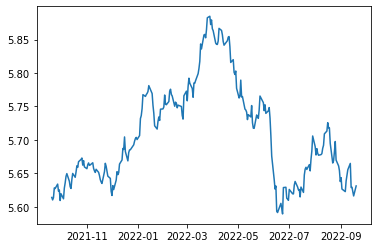

<Figure size 900x500 with 0 Axes>

In [23]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.figure(figsize=(9,5), dpi=100)

In [24]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

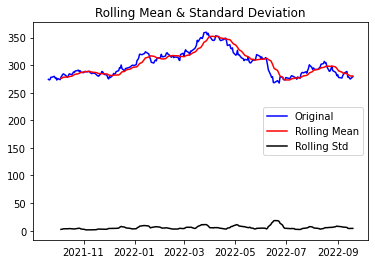

In [25]:
plot_rolling_statistics(ts, window=12)

# Statsmodels 패키지에서 제공하는 adfuller 메서드를 사용하여 주어진 시계열의 안정성 확인
Stationary 하게 만들기
- 정성적인 분석을 통해 보다 안정적인 특성을 가지도록 기존의 시계열 데이터를 가공, 변형
- 시계열 분석 기법 사용

In [26]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### p-value 가  0.5정도이다.

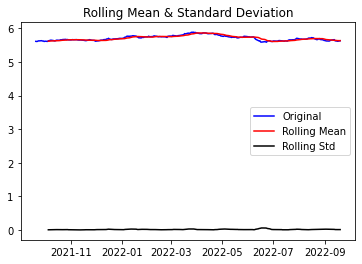

Results of Dickey-Fuller Test:
Test Statistic                  -1.435369
p-value                          0.565207
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


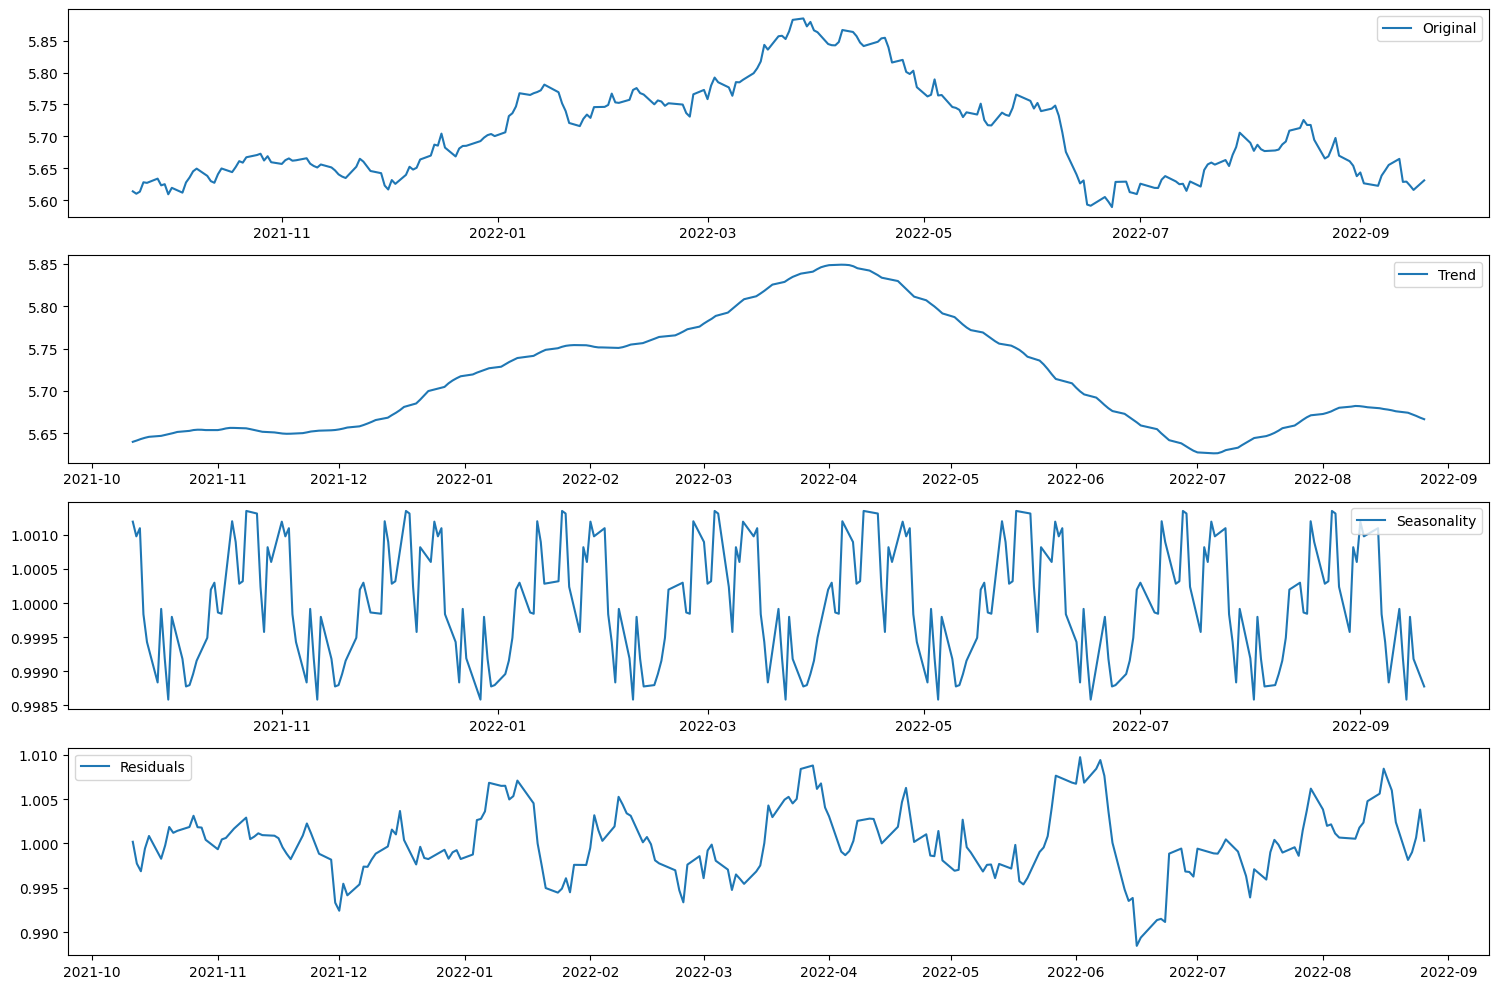

In [27]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15,10), dpi=100)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [28]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.146717
p-value                          0.000011
#Lags Used                       3.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


### p-value 가  0.000011정도이다.
더 작아졌다.

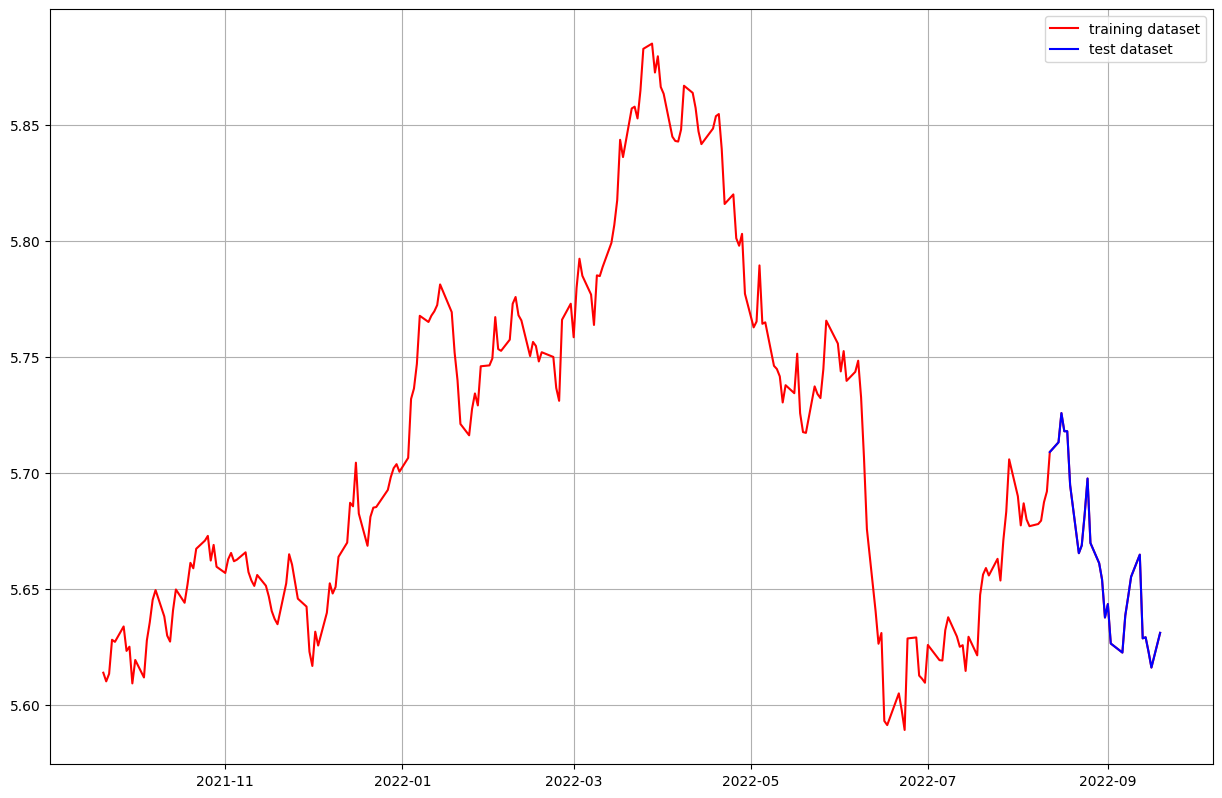

In [29]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,10), dpi=100)
plt.grid(True)
plt.plot(ts_log, c = 'r', label = 'training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

<Figure size 1500x1000 with 0 Axes>

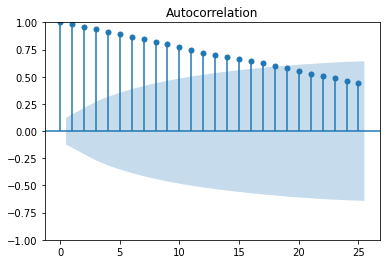

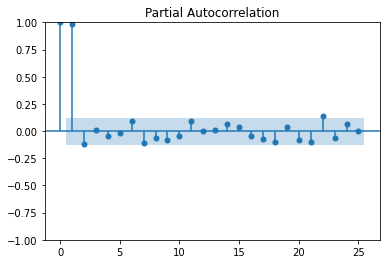

In [30]:
import warnings
warnings.filterwarnings('ignore') #경고 무시
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15,10), dpi=100)
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
# ACF -> MA : q 시차에 따른 관측치들 사이의 관련성
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
# PACF -> AR: p = 1이 적합 두 시차의 관측치
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.455879e+01
p-value                        4.832350e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


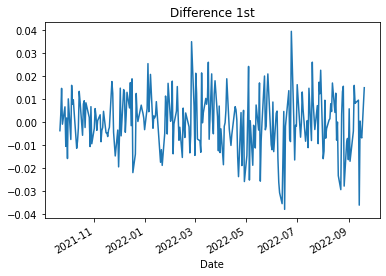

In [31]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')


augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.139437e+00
p-value                        3.354003e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


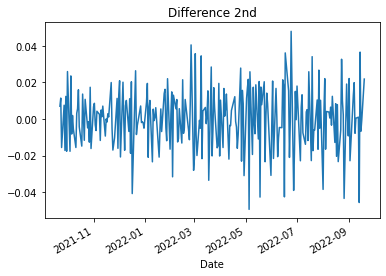

In [32]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [33]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(6, 0, 1))
# p = 6, d = 0, q = 0 으로 정해서 AR의 경향을 더 따르는것같아서 p=6 으로 설정.
# d= 1이상을 넣으면 MAPE 값이 크게 늘어나 0으로 설정
# q = 1에 넣으면 MAPE 0.01퍼센트 포인트가 늘어나고, 시계열 데이터가 AR이나 MA 중 하나의 경향을 가졌다고 하니, q = 0으로 했다.
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(6, 0, 1)   Log Likelihood                 677.545
Date:                Thu, 29 Sep 2022   AIC                          -1337.090
Time:                        15:19:54   BIC                          -1306.305
Sample:                             0   HQIC                         -1324.666
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6967      0.036    157.294      0.000       5.626       5.768
ar.L1          0.6909      1.331      0.519      0.604      -1.918       3.300
ar.L2          0.3190      1.377      0.232      0.8

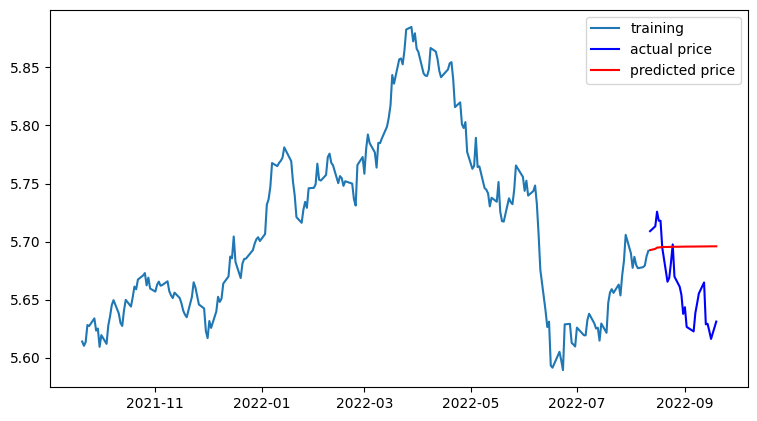

In [34]:

fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  184.41759926616308
MAE:  11.93921045548695
RMSE:  13.580044155530684
MAPE: 4.21%


# 회고는 3. KO_예측.ipynb 에 적혀있습니다.